In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as mticker

from glob import glob

import datetime
from datetime import timedelta

from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature

from matplotlib import colors as c
import flox
from flox.xarray import xarray_reduce

import dask

ERROR 1: PROJ: proj_create_from_database: Open of /home/bwallace/anaconda3/envs/analysis/share/proj failed


In [2]:
from dask.distributed import Client

client = Client(n_workers=10)

print(client.dashboard_link)

from distributed import get_client
worker_client=get_client()

http://127.0.0.1:8787/status


In [3]:
from scipy.stats import mannwhitneyu
import dask.array as da
from dask import delayed
        
def calc_j_row(ds1,ds2,iterations,i):
    j_results=[]
    for j in range(iterations):
        sp=mannwhitneyu(ds1[:,i,j],ds2[:,i,j])
        j_results.append(sp)
    return j_results

def dask_grid_sig(ds1, ds2, client=worker_client, expected_dims=(15, 96, 288)): #15,44,69 for coarse; 15,899,1399 for regular
    r"""Performs a grid-to-grid significance test on ds1 and ds2.
    Returns a grid of the same size with p-values from the Mann
    Whitney U test.
    
    Parameters
    ----------
    ds1: (t, y, x) ndarray
        An ndarray in the format of (time, y, x) and shape of expected_dims. 
    ds2: (t, y, x) ndarray
        An ndarray in the format of (time, y, x) and shape of expected_dims.  
    expected_dims: tuple
        The expected shape of ds1 and ds2. Default is (15, 44, 69).
    Returns
    -------
    results: (y, x) ndarray
        Results of significance testing in the form of p-values.
    """    
    
    if ds1.shape == expected_dims and ds2.shape == expected_dims:
        #Since zeros would be < 0.05
        #results = np.ones(shape=(ds1.shape[1], ds1.shape[2]), dtype=float)
        results=[]
        
        future_ds1=client.scatter(ds1)
        future_ds2=client.scatter(ds2)

        for i in range(ds1.shape[1]):
            results.append(delayed(calc_j_row)(future_ds1,future_ds2,ds2.shape[2],i))                    

        return results
    
    else:
        
        raise ValueError("Dimensions are not as expected, given", ds1.shape, "expected", expected_dims)


In [4]:
states_provinces = NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

In [5]:
coord=xr.open_dataset('../data/cesm_coords.nc')

lat=coord.lat
lon=coord.lon

In [6]:
coarsen_size=20 #make sure this is consistent with the coarsen_size specified in calculate_mcs_anomaly

wrf_native_coords=xr.open_dataset('../data/geog_info.nc')
wrf_lat=wrf_native_coords.XLAT_M[0]
wrf_lon=wrf_native_coords.XLONG_M[0]

wrf_lat_coarse=wrf_lat.coarsen(south_north=coarsen_size,boundary='trim').mean()\
.coarsen(west_east=coarsen_size,boundary='trim').mean()
wrf_lon_coarse=wrf_lon.coarsen(south_north=coarsen_size,boundary='trim').mean()\
.coarsen(west_east=coarsen_size,boundary='trim').mean()

In [7]:
with open('../data/lwa_results.pkl', 'rb') as f:
    results = pickle.load(f)

with open('../data/z500_avg.pkl', 'rb') as f:
    z500 = pickle.load(f)

In [9]:
# Set some projections for our data (Plate Carree)
# and output maps (Lambert Conformal)

# Data projection;
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-95.,
                                 central_latitude=40.,
                                 standard_parallels=[30, 60])

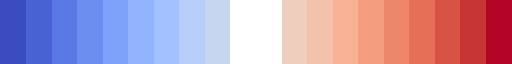

In [10]:
new_colors=plt.get_cmap('coolwarm')(np.linspace(0,1,256))
new_colors[120:140]=[1,1,1,1]

# Choose a colormap
original_cmap = plt.get_cmap('viridis')
# Resample the colormap to have 20 bins
resampled_cmap = mcolors.ListedColormap(original_cmap(np.linspace(0, 1, 12)))

seis_cmap=mcolors.ListedColormap(new_colors).resampled(20)
seis_cmap

In [11]:
freq_sig = np.array(dask.compute(dask_grid_sig(results['CWACT_historical_freq'], results['CWACT_end_of_century_8p5_freq'], client=worker_client))[0])[:,:,1]

int_sig = np.array(dask.compute(dask_grid_sig(results['CWACT_historical_int'], results['CWACT_end_of_century_8p5_int'], client=worker_client))[0])[:,:,1]

sig = np.array(dask.compute(dask_grid_sig(results['CWACT_historical'], results['CWACT_end_of_century_8p5'], client=worker_client))[0])[:,:,1]

In [12]:
with open('../data/iso_avg.pkl', 'rb') as f:
    allpaths_ds = pickle.load(f)

In [13]:
height_ranges={
    90000:{
        'min':975,
        'max':1100,
        'diffmin':-25,
        'diffmax':25,
        'diffrange':10,
    },
    85000:{
        'min':1450,
        'max':1575,
        'diffmin':-50,
        'diffmax':50,
        'diffrange':20,
    },
    70000:{
        'min':3000,
        'max':3200,
        'diffmin':-150,
        'diffmax':150,
        'diffrange':40,
    },
    50000:{
        'min':5600,
        'max':5950,
        'diffmin':-300,
        'diffmax':300,
        'diffrange':120,
    }
}

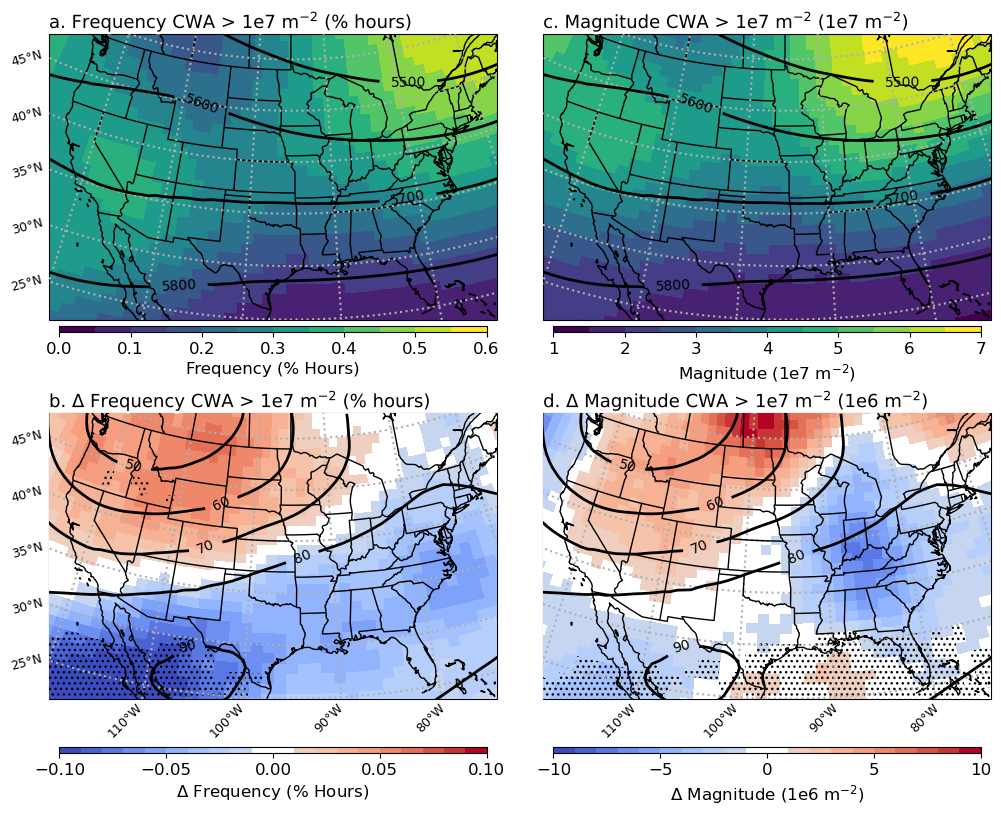

In [14]:
xrng,yrng=10, 10

ssn='MAM'
sel_hgt = 50000

fig=plt.figure(constrained_layout=True, figsize=(10,8))
gs=fig.add_gridspec(2,2)


ax=fig.add_subplot(gs[0,0], projection=plotproj)
ax.set_extent([-120, -74, 25, 50], ccrs.PlateCarree())

c=ax.pcolormesh(lon, lat, results['CWACT_historical_freq'].mean('water_year'), vmin=0, vmax=0.6, cmap = resampled_cmap, transform=dataproj)

#cntr = ax.contour(lon, lat, z500['avg_historical'].mean('water_year'),np.arange(0, 10100, 100), linewidths = 2, colors='k', transform=dataproj)
#ax.clabel(cntr,cntr.levels,fontsize=10)

contr = ax.contour(wrf_lon_coarse, wrf_lat_coarse,
                   allpaths_ds['historical_'+ssn+'_mean']['GHT_PL'].\
                   mean('water_year').\
                   sel(iso_lev = sel_hgt),
                   np.arange(0, 10100, 100),
                   colors='k', linewidths=2, linestyles='-',
                   transform=dataproj, zorder=6)

ax.clabel(contr,contr.levels,fontsize=10)

ax.coastlines()
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=1)

t=ax.text(0,1.02,'a. Frequency CWA > 1e7 m$^{-2}$ (% hours)',
          horizontalalignment='left',
          size=13,color='k',
          path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
          transform=ax.transAxes,zorder=10)
#t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))
  
ll=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linestyle=':',lw=1.5,zorder=5)
ll.top_labels=False
ll.right_labels=False
#ll.left_labels = False
ll.bottom_labels=False
ll.xlocator = mticker.FixedLocator([-120,-110,-100,-90,-80,-70])
ll.rotate_labels=True
ll.xlabel_style = {'rotation':45,  'size':9}
ll.ylabel_style = {'rotation':15, 'size':9}

cbar_axs = []
cbar_axs.append(ax)
cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=70,fraction=0.02,pad=0.02,
                 ticks=np.arange(0,0.7,0.1))
cbar.set_label('Frequency (% Hours)',fontsize=12)

cbar.ax.tick_params(labelsize=12)


ax=fig.add_subplot(gs[1,0], projection=plotproj)
ax.set_extent([-120, -74, 25, 50], ccrs.PlateCarree())

c=ax.pcolormesh(lon, lat, results['CWACT_end_of_century_8p5_freq'].mean('water_year') - results['CWACT_historical_freq'].mean('water_year'), vmin=-0.1, vmax=0.1, cmap=seis_cmap, zorder=5, transform=dataproj)

plt.fill_between([-1e10,1e10],-1e10,1e10,hatch='...',color='none',edgecolor='k',zorder=5)

ax.pcolormesh(lon, lat, 
              results['CWACT_end_of_century_8p5_freq'].mean('water_year') - results['CWACT_historical_freq'].mean('water_year').\
              where(freq_sig>0.05), 
              vmin=-0.1, vmax=0.1, cmap=seis_cmap, zorder=5, transform=dataproj)

contr=ax.contour(wrf_lon_coarse,wrf_lat_coarse,
           allpaths_ds['end_of_century_8p5_'+ssn+'_mean']['GHT_PL'].\
           mean('water_year').\
           sel(iso_lev = sel_hgt)-
           allpaths_ds['historical_'+ssn+'_mean']['GHT_PL'].\
           mean('water_year').\
           sel(iso_lev = sel_hgt),
           np.arange(-300, 300, 10),colors='k',linewidths=2,
           transform=dataproj,zorder=6)
ax.clabel(contr,contr.levels,fontsize=10)

ax.coastlines(zorder=6)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1, zorder=6)
ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=6)

t=ax.text(0,1.02,'b. $\Delta$ Frequency CWA > 1e7 m$^{-2}$ (% hours)',
          horizontalalignment='left',
          size=13,color='k',
          path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
          transform=ax.transAxes,zorder=10)
#t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

ll=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linestyle=':',lw=1.5,zorder=5)
ll.top_labels=False
ll.right_labels=False
#ll.left_labels = False
#ll.bottom_labels=False
ll.xlocator = mticker.FixedLocator([-120,-110,-100,-90,-80,-70])
ll.rotate_labels=True
ll.xlabel_style = {'rotation':45,  'size':9}
ll.ylabel_style = {'rotation':15, 'size':9}

cbar_axs = []
cbar_axs.append(ax)
cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=70,fraction=0.02,pad=0.02,
                 ticks=np.arange(-0.1,0.15,0.05))
cbar.set_label('$\Delta$ Frequency (% Hours)',fontsize=12)

cbar.ax.tick_params(labelsize=12)

ax=fig.add_subplot(gs[0,1], projection=plotproj)
ax.set_extent([-120, -74, 25, 50], ccrs.PlateCarree())

c=ax.pcolormesh(lon, lat, results['CWACT_historical_int'].mean('water_year')/1e7, vmin=1, vmax=7, cmap = resampled_cmap, transform=dataproj)

#cntr = ax.contour(lon, lat, z500['avg_historical'].mean('water_year'),np.arange(0, 10100, 100), linewidths = 2, colors='k', transform=dataproj)
#ax.clabel(cntr,cntr.levels,fontsize=10)

contr = ax.contour(wrf_lon_coarse, wrf_lat_coarse,
                   allpaths_ds['historical_'+ssn+'_mean']['GHT_PL'].\
                   mean('water_year').\
                   sel(iso_lev = sel_hgt),
                   np.arange(0, 10100, 100),
                   colors='k', linewidths=2, linestyles='-',
                   transform=dataproj, zorder=6)

ax.clabel(contr,contr.levels,fontsize=10)


ax.coastlines(zorder=5)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1, zorder=5)
ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=5)

t=ax.text(0,1.02,'c. Magnitude CWA > 1e7 m$^{-2}$ (1e7 m$^{-2}$)',
          horizontalalignment='left',
          size=13,color='k',
          path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
          transform=ax.transAxes,zorder=10)
#t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

ll=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linestyle=':',lw=1.5,zorder=5)
ll.top_labels=False
ll.right_labels=False
ll.left_labels = False
ll.bottom_labels=False
ll.xlocator = mticker.FixedLocator([-120,-110,-100,-90,-80,-70])
ll.rotate_labels=True
ll.xlabel_style = {'rotation':45,  'size':9}
ll.ylabel_style = {'rotation':15, 'size':9}

cbar_axs = []
cbar_axs.append(ax)
cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=70,fraction=0.02,pad=0.02,
                 ticks=np.arange(1,8,1))
cbar.set_label('Magnitude (1e7 m$^{-2}$)',fontsize=12)

cbar.ax.tick_params(labelsize=12)

ax=fig.add_subplot(gs[1,1], projection=plotproj)
ax.set_extent([-120, -74, 25, 50], ccrs.PlateCarree())

c=ax.pcolormesh(lon, lat, (results['CWACT_end_of_century_8p5_int'].mean('water_year') - results['CWACT_historical_int'].mean('water_year'))/1e6, vmin=-10, vmax=10, cmap=seis_cmap, zorder=5, transform=dataproj)

plt.fill_between([-1e10,1e10],-1e10,1e10,hatch='...',color='none',edgecolor='k',zorder=5)

ax.pcolormesh(lon, lat, 
              (results['CWACT_end_of_century_8p5_int'].mean('water_year') - results['CWACT_historical_int'].mean('water_year').\
              where(int_sig>0.05))/1e6, 
              vmin=-10, vmax=10, cmap=seis_cmap, zorder=5, transform=dataproj)

contr=ax.contour(wrf_lon_coarse,wrf_lat_coarse,
           allpaths_ds['end_of_century_8p5_'+ssn+'_mean']['GHT_PL'].\
           mean('water_year').\
           sel(iso_lev = sel_hgt)-
           allpaths_ds['historical_'+ssn+'_mean']['GHT_PL'].\
           mean('water_year').\
           sel(iso_lev = sel_hgt),
           np.arange(-300, 300, 10),colors='k',linewidths=2,
           transform=dataproj,zorder=6)
ax.clabel(contr,contr.levels,fontsize=10)


ax.coastlines(zorder=6)
ax.add_feature(states_provinces, edgecolor='black', linewidth=1, zorder=6)
ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=6)

t=ax.text(0,1.02,'d. $\Delta$ Magnitude CWA > 1e7 m$^{-2}$ (1e6 m$^{-2}$)',
          horizontalalignment='left',
          size=13,color='k',
          path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
          transform=ax.transAxes,zorder=10)
#t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

ll=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linestyle=':',lw=1.5,zorder=5)
ll.top_labels=False
ll.right_labels=False
ll.left_labels = False
#ll.bottom_labels=False
ll.xlocator = mticker.FixedLocator([-120,-110,-100,-90,-80,-70])
ll.rotate_labels=True
ll.xlabel_style = {'rotation':45,  'size':9}
ll.ylabel_style = {'rotation':15, 'size':9}

cbar_axs = []
cbar_axs.append(ax)
cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=70,fraction=0.02,pad=0.02,
                 ticks=np.arange(-10, 15, 5))
cbar.set_label('$\Delta$ Magnitude (1e6 m$^{-2}$)',fontsize=12)

cbar.ax.tick_params(labelsize=12)

plt.show()
plt.close()